# Import Required Libraries
Import the necessary libraries, including TensorFlow, NumPy, and Pandas.

Run this command to install necessary libraries:

```bash
pip install numpy pandas requests scikit-learn tensorflow matplotlib


In [119]:
# Import Required Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
# Plot the predictions against the actual values
import matplotlib.pyplot as plt

# Load and Preprocess Data
Load the stock price data, preprocess it by normalizing and creating sequences for training.

In [120]:
import copy
from hmac import new
from operator import index
import select
from venv import create
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Load the stock price data
data = pd.read_csv('./merged_scaled_data (1).csv')

copy_data = data.copy()
target = "Q avg to Q avg Price % Change"
index_target = data.columns.get_loc(target)
# Normalize the data
new_data = data[["Period Ending",target]]
#drop nan values
#having the nan values in the rows affect the traiing as the loss can not be calcluated
#so we drop the rows with nan values
new_data = new_data.dropna()
data = data.dropna()
columns_to_drop = ["Ticker Symbol","Period Ending","Sector"]
target_data = [target] + columns_to_drop
#####################Trying out Lasso Ridge Regression##########################
target_data = np.array([target]+columns_to_drop)
X = data.drop(columns=target_data)
y = data[target].values
X = X.dropna()
# Scale the features

# Train LASSO with cross-validation for alpha selection
lasso_cv = LassoCV(cv=5, random_state=0,max_iter=5000).fit(X, y)

# Get the selected features
selected_features = np.array(np.where(lasso_cv.coef_ != 0)[0])
print(selected_features)

new_features = np.append(selected_features,index_target)
print(new_features)
selected_features = data.columns[np.array(new_features)]
data = copy_data[selected_features]
print(data.columns)

#####################Trying out Lasso Ridge Regression##########################


# Create sequences for training
def create_sequences(data, seq_length, target_column,exclude_columns=None):
    """
    Creates sequences of data for LSTM training.

    Args:
        data (pd.DataFrame): The dataframe containing features and target.
        seq_length (int): The number of timesteps in each sequence.
        target_column (str): The name of the target column.
        exclude_columns (list, optional): List of column names to exclude from features.

    Returns:
        np.array: Array of feature sequences.
        np.array: Array of target values.
    """
    x = []
    y = []
    for i in range(len(data) - seq_length):
        # Define the start and end indices for the sequence
        start_idx = i
        end_idx = i + seq_length

        # Select the sequence slice
        seq_slice = data.iloc[start_idx:end_idx]

        # Exclude specified columns and the target column
        if exclude_columns:
            feature_seq = seq_slice.drop(columns=exclude_columns).values
        else:
            feature_seq = seq_slice.drop(columns=[target_column]).values

        x.append(feature_seq)

        # Select the target value following the sequence
        target_val = data.iloc[end_idx][target_column]
        y.append(target_val)

    return np.array(x), np.array(y)
def create_sequences2(data, seq_length):
    x = []
    y = []
    if len(data) <= seq_length:
        raise ValueError("The length of features must be greater than the sequence length.")
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)


seq_length = 60
data = data.astype(np.float64)
data = data.dropna()
x, y = create_sequences(data, seq_length,target)
# x, y = create_sequences2(new_data, seq_length)
# x, y = create_sequences(new_data1,seq_length,target)
# Split the data into training and validation sets
split = int(0.8 * len(x))
print(x.shape)
print(y.shape)
x_train, x_val = x[:split], x[split:]
y_train, y_val = y[:split], y[split:]

# scaler = MinMaxScaler()
# y_train = scaler.fit_transform(y_train.reshape(-1, 1))
# y_val = scaler.transform(y_val.reshape(-1, 1))
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
# x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2])

[11 22 23 31 34 43 45 54 61 76 77]
[11 22 23 31 34 43 45 54 61 76 77 79]
Index(['Common Stocks', 'Goodwill', 'Gross Margin', 'Long-Term Debt',
       'Misc. Stocks', 'Net Income-Cont. Operations', 'Non-Recurring Items',
       'Other Liabilities', 'Research and Development', 'Earnings Per Share',
       'Estimated Shares Outstanding', 'Q avg to Q avg Price % Change'],
      dtype='object')
(1229, 60, 11)
(1229,)


In [121]:

# Check for NaN or Inf values

def check_nan_inf(array, name):
    print(f"\nChecking {name}:")
    print(f"Number of NaNs: {np.isnan(array).sum()}")
    print(f"Number of Infs: {np.isinf(array).sum()}")
print(x_train.dtype)  # Should be float32 or float64
print(y_train.dtype)  # Should be float32 or float64
print(x_val.dtype)
print(y_val.dtype)
print(x_train.shape)  # Should be (num_samples, seq_length, num_features)
check_nan_inf(x_train, "x_train")
check_nan_inf(y_train, "y_train")
check_nan_inf(x_val, "x_val")
check_nan_inf(y_val, "y_val")

float64
float64
float64
float64
(983, 60, 11)

Checking x_train:
Number of NaNs: 0
Number of Infs: 0

Checking y_train:
Number of NaNs: 0
Number of Infs: 0

Checking x_val:
Number of NaNs: 0
Number of Infs: 0

Checking y_val:
Number of NaNs: 0
Number of Infs: 0


# Build the LSTM Model
Define the LSTM model architecture using TensorFlow's Keras API.

In [122]:
# Build the LSTM Model


units = 64

num_features = x_train.shape[2]
activation = 'tanh'
initial_learning_rate = 0.000001

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate,clipnorm=1.0)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(None, num_features)),
    tf.keras.layers.LSTM(units=units),
    tf.keras.layers.Dense(1,activation=activation)
])

model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()
# Train the model
history = model.fit(
    x_train, 
    y_train, 
    epochs=50, 
    batch_size=64, 
    validation_data=(x_val, y_val)
    )
# Evaluate the model

# by default 
loss = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss}')

c:\Users\erich\OneDrive\Documents\GitHub\stock_price_prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                  │ (None, None, 64)       │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 108.5054 - val_loss: 124.3603
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 97.9076 - val_loss: 124.3572
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 111.1803 - val_loss: 124.3539
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 120.3037 - val_loss: 124.3505
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 106.8245 - val_loss: 124.3474
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 105.7461 - val_loss: 124.3442
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 104.1975 - val_loss: 124.3412
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 101.4419 - val_loss: 124.3381
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 111.0904 - val_loss: 124.3349
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 99.7432 - val_loss: 124.3317
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 102.6674 - val_loss: 124.3287
Epoch 12/50
16/16 ━━━

# Evaluate the Model
Evaluate the model's performance on a test dataset.

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 106.0985
Validation Loss: 103.74148559570312
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Mean Squared Error: 124.20103725045517
Root Mean Squared Error: 11.144551908912945
R^2 Score: -0.08264477452116603
Average Difference: 8.430240290999171
Actual Values Mean: 3.1289430894308947
Max Prediction: 0.15764348208904266
Min Prediction: -0.0573449432849884


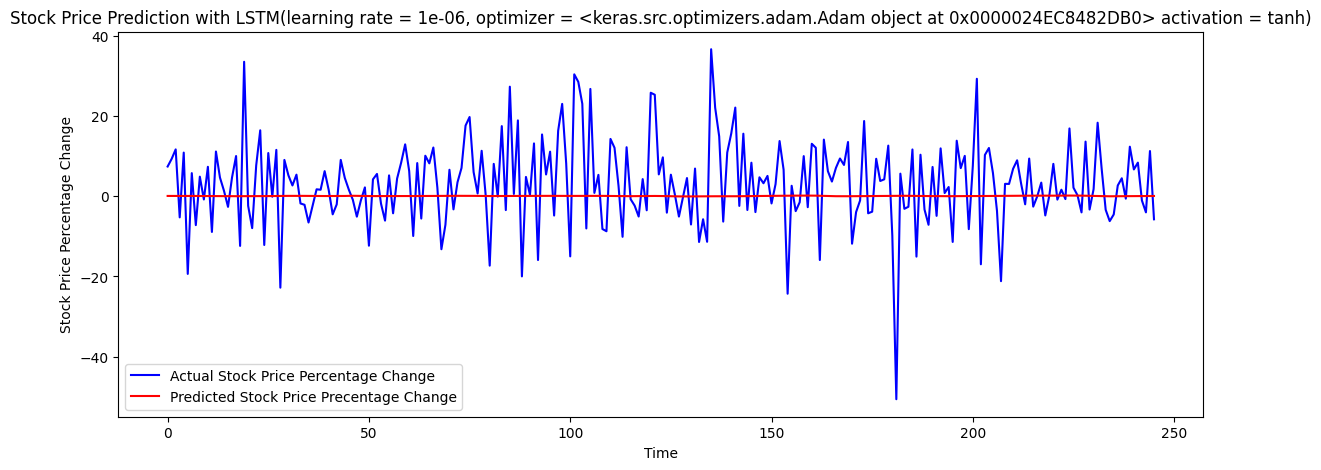

In [ ]:
# Evaluate the Model
from logging import root
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Evaluate the model's performance on the test dataset
loss = model.evaluate(x_train, y_train)
print(f'Validation Loss: {loss}')

# Make predictions on |the validation set
predictions = model.predict(x_val)

# Inverse transform the predictions and actual values to get the original scale
actual = y_val.reshape(-1, 1)
mse_val = mean_squared_error(actual, predictions)
print(f'Mean Squared Error: {mse_val}')
root_mse_val = np.sqrt(mse_val)
print(f'Root Mean Squared Error: {root_mse_val}')
# had used r2 score before but for time series data it is not really that good for evaluation because idata in time series exhibits autocorrelation
r2 = r2_score(actual, predictions)
print(f'R^2 Score: {r2}')
##### calculuating the average differences between actual and predicted values
diff = np.abs(actual - predictions)
avg_diff = np.mean(diff)
print(f'Average Difference: {avg_diff}')
# print the actual values mean
print(f'Actual Values Mean: {np.mean(actual)}')

#printing the max and min prediction
print(f'Max Prediction: {np.max(predictions)}')
print(f'Min Prediction: {np.min(predictions)}')


plt.figure(figsize=(14, 5))
plt.plot(actual, color='blue', label='Actual Stock Price Percentage Change')
plt.plot(predictions, color='red', label='Predicted Stock Price Precentage Change')
title = f'Stock Price Prediction with LSTM(learning rate = {initial_learning_rate}, optimizer = {"Adam"} activation = {activation})'
plt.title(title)
# time is the 250 differnt time stamps from 2012- 2016
plt.xlabel('Time')
plt.ylabel('Stock Price Percentage Change')
plt.legend()
plt.show()